In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
%matplotlib inline

In [2]:
# Set ipython's max row display
pd.set_option('display.max_row', 10)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 200)

# Sampling

In [3]:
data = pd.read_csv('all_data.csv')

In [4]:
df_positive_ex = data[data['is_blighted'] == 1]

#split positive examples to preserve class ratio
pos_train = df_positive_ex.sample(frac=0.8, random_state=10)
pos_test = df_positive_ex.drop(pos_train.index)

In [5]:
df_negative_ex = data[(data['is_blighted'] == 0)]

#split negative examples to preserve class ratio
neg_train = df_negative_ex.sample(frac=0.8, random_state=10)
neg_test = df_negative_ex.drop(neg_train.index)

In [6]:
len(df_positive_ex)/len(df_negative_ex)

0.018847567974509392

In [7]:
#combine train/test and shuffle data
train = pd.concat([pos_train, neg_train])
train.reindex(np.random.permutation(train.index))

test = pd.concat([pos_test, neg_test])
test.reindex(np.random.permutation(test.index));

In [8]:
#uncomment to remove blight 311 and fire features
#predictors = list(data.ix[:, 3:34].columns)
predictors = list(data.ix[:, 3:-1].columns)
target = 'is_blighted'

In [9]:
def modelfit(alg, dtrain, predictors, fit=True, performCV=True, cv_folds=5):
    #fit the algorithm on the data
    if fit:
        alg.fit(dtrain[predictors], dtrain.ix[:, -1])
        
    #predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], dtrain.ix[:, -1], cv=cv_folds, scoring='f1',
                                   verbose=2, n_jobs=-1)
    
    #print model report:
    print("Model Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain.ix[:, -1].values, dtrain_predictions))
    #print("AUROC Score (train): %f" % metrics.roc_auc_score(dtrain.ix[:, -1], dtrain_predprob))
    print("F1 Score (train): %f" % metrics.f1_score(dtrain.ix[:, -1], dtrain_predictions))
    print("Precision Score (train): %f" % metrics.precision_score(dtrain.ix[:, -1], dtrain_predictions))
    print("Recall Score (train): %f" % metrics.recall_score(dtrain.ix[:, -1], dtrain_predictions))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))

In [10]:
def modeltest(alg, dtest, predictors):
    #Predict test set:
    dtest_predictions = alg.predict(dtest[predictors])
    #dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]

    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtest.ix[:, -1].values, dtest_predictions))
    #print("AUROC Score (test): %f" % metrics.roc_auc_score(dtest.ix[:, -1], dtest_predprob))
    print("F1 Score (test): %f" % metrics.f1_score(dtest.ix[:, -1], dtest_predictions))
    print("Precision Score (test): %f" % metrics.precision_score(dtest.ix[:, -1], dtest_predictions))
    print("Recall Score (test): %f" % metrics.recall_score(dtest.ix[:, -1], dtest_predictions))
    

# Random Forest

In [11]:
baseline = RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=10)

modelfit(baseline, train, predictors, fit=True, performCV=True)

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] .......................................................  -   0.4s
[CV]  ................................................................
[CV] .......................................................  -   0.6s
[CV] .......................................................  -   0.4s
[CV] .......................................................  -   0.5s
[CV] .......................................................  -   0.2s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.4s finished


Model Report
Accuracy : 0.9968
F1 Score (train): 0.905537
Precision Score (train): 0.994947
Recall Score (train): 0.830872
CV Score : Mean - 0.2008811 | Std - 0.01160515 | Min - 0.1906023 | Max - 0.2222222


In [12]:
modeltest(baseline, test, predictors)


Model Report
Accuracy : 0.9801
F1 Score (test): 0.185600
Precision Score (test): 0.384106
Recall Score (test): 0.122363


In [13]:
best_params = {'max_features': 0.5, 'min_samples_leaf': 5, 'n_estimators': 150}
#for feature dropped model:
#best_params = {'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 150}
#best_params = {}

In [14]:
#param_test = {'n_estimators': [150],
#              'min_samples_leaf': [2, 3, 5, 7],
#              'max_features': [1.0, 0.5, 0.3, 'sqrt']
#              }
#gsearch = GridSearchCV(estimator = RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=10), 
#param_grid = param_test, scoring='f1',n_jobs=-1,iid=False, cv=5, verbose=2)
#gsearch.fit(train[predictors],train[target])
#gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

In [15]:
#best_params.update(gsearch.best_params_)

# Model Performance

In [16]:
#est = gsearch.best_estimator_
est = RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=10, **best_params)

In [17]:
modelfit(est, train, predictors, fit=True, performCV=True)

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] .......................................................  -   2.2s
[CV]  ................................................................
[CV] .......................................................  -   2.1s
[CV] .......................................................  -   1.6s
[CV] .......................................................  -   1.6s
[CV] .......................................................  -   0.5s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 12.5min finished


Model Report
Accuracy : 0.9601
F1 Score (train): 0.476752
Precision Score (train): 0.314837
Recall Score (train): 0.981540
CV Score : Mean - 0.3101108 | Std - 0.003914965 | Min - 0.3055032 | Max - 0.3162953


In [18]:
modeltest(est, test, predictors)


Model Report
Accuracy : 0.9478
F1 Score (test): 0.312960
Precision Score (test): 0.206834
Recall Score (test): 0.642757


In [19]:
cm = metrics.confusion_matrix(train[target], est.predict(train[predictors]))
matrix = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'],
            columns=['Predicted Negative', 'Predicted Positive'])
matrix
#print(matrix.to_html())

,Predicted Negative,Predicted Positive
Actual Negative,289640,12150
Actual Positive,105,5583


In [20]:
cm = metrics.confusion_matrix(test[target], est.predict(test[predictors]))
matrix = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'],
            columns=['Predicted Negative', 'Predicted Positive'])
matrix
#print(matrix.to_html())

,Predicted Negative,Predicted Positive
Actual Negative,71942,3505
Actual Positive,508,914


In [21]:
test['predict_proba'] = est.predict_proba(test[predictors])[:,1]
test['prediction'] = est.predict(test[predictors])

In [22]:
data['predict_proba'] = est.predict_proba(data[predictors])[:,1]
data['prediction'] = est.predict(data[predictors])

In [23]:
#test.to_csv('predictions.csv', index=False)

# Feature Importance

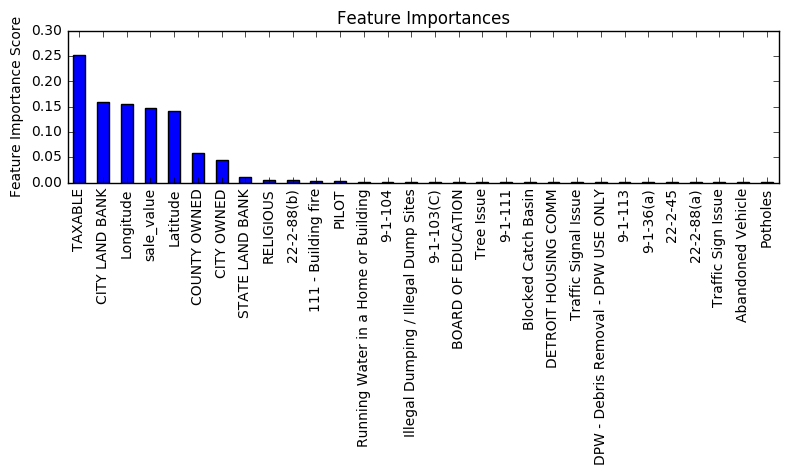

In [24]:
fig, ax = plt.subplots()
feat_imp = pd.Series(est.feature_importances_, predictors).sort_values(ascending=False)[:30]
feat_imp.plot(kind='bar', title='Feature Importances')
plt.tight_layout()
fig.set_size_inches(8, 9)
plt.ylabel('Feature Importance Score')
plt.savefig('feature_importance.png', dpi=300, alpha=True)

# Analysis

In [25]:
train['predict_proba'] = est.predict_proba(train[predictors])[:,1]
train['prediction'] = est.predict(train[predictors])

In [26]:
bins = np.arange(.50, 1.01, 0.1)

In [27]:
pd.cut(train['predict_proba'], bins)

35912     (0.8, 0.9]
187767    (0.7, 0.8]
204663      (0.9, 1]
125538    (0.6, 0.7]
66128            NaN
             ...    
258530    (0.5, 0.6]
287527           NaN
202285           NaN
231482           NaN
321723           NaN
Name: predict_proba, dtype: category
Categories (5, object): [(0.5, 0.6] < (0.6, 0.7] < (0.7, 0.8] < (0.8, 0.9] < (0.9, 1]]

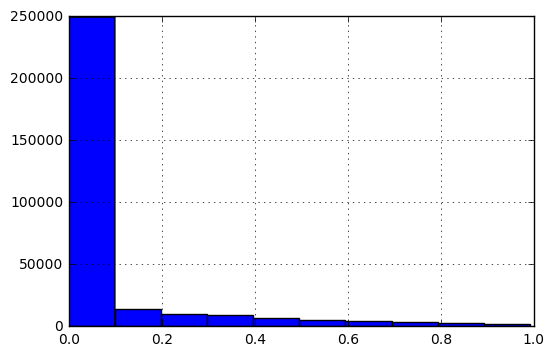

In [28]:
train['predict_proba'].hist()

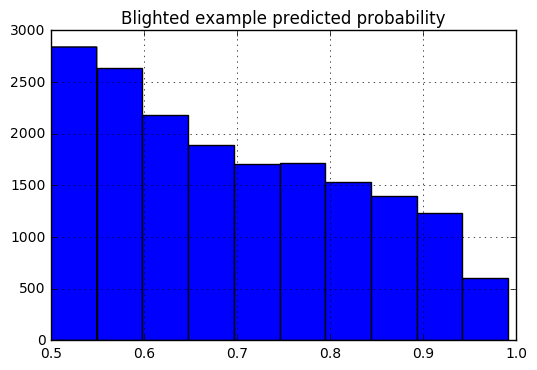

In [29]:
train[train['prediction'] == 1]['predict_proba'].hist()
plt.title('Blighted example predicted probability')

In [30]:
missed = train[train['prediction'] != train['is_blighted']]

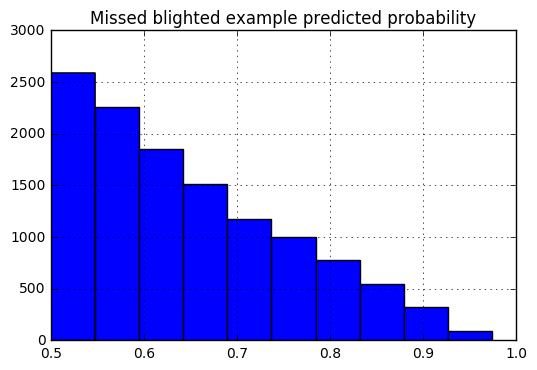

In [31]:
missed[missed['prediction'] == 1]['predict_proba'].hist()
plt.title('Missed blighted example predicted probability')

In [32]:
missed[(missed['prediction'] == 1) & (missed['predict_proba'] < 0.6)].iloc[:2,:]

,address,parcel_no,poly,sale_value,Latitude,Longitude,2YR NON-PROFIT HOUSE,BENEVOLENT/CHARITY,BOARD OF EDUCATION,CITY LAND BANK,CITY OWNED,COMMUNICATIONS,COUNTY LAND BANK,COUNTY OWNED,DETROIT HOUSING COMM,DISABLED VETERAN,EDUCATION/SCIENTIFIC,FEDERAL,HOSPITAL,NON-PROFIT,PA 245,PARSONAGE,PILOT,PROJECTS,PUBLIC LIGHTING,RAILROAD,REAL ESTATE DIVISION,RELIGIOUS,SEMTA,STATE LAND BANK,STATE OWNED,STATUTORY,TAXABLE,WATER DEPARTMENT,22-2-88(b),9-1-104,9-1-110(a),22-2-88(a),22-2-43,9-1-113,9-1-202,61-85.0100/32.0066,9-1-83 - (Structures < 5 stories),9-1-81(a),9-1-36(a),9-1-82(d) - (Structures < 5 stories),9-1-82(d) - (Dwelling),9-1-43(a) - (Dwelling),9-1-43(a) - (Structures),9-1-13,9-1-111,22-2-45,22-2-44,61-5-14 (9),9-1-107,9-1-111(a),9-1-50(a),61-85.0100/32.0031,22-2-16,22-2-17(a),22-2-49(a),9-1-82(b),9-1-91,61-82.0100/32.0066,9-1-101,22-2-41(b),61-81.0100/32.0066,9-1-103(C),9-1-36(d),9-1-36(c),61-84.0100/32.0076B,9-1-205,22-2-88,22-2-21(b),22-2-83(a)(b)(c),9-1-201(a),9-1-45,22-2-83(b),9-1-204,61-14-175,22-2-83(c),22-2-83,22-2-49(b),22-2-22(a),61-83.0100/32.0031,9-1-83 - (Dwelling),22-2-61,22-2-22,9-1-110(b),22-2-56,22-2-83(a)(c),9-1-81(e),9-1-105,22-2-38,22-2-49(c),61-5-18,9-1-112,9-1-82(d) - (Building 5 or more stories),22-2-49(d),61-84.0100/45.0807,...,522 - Water or steam leak,444 - Power line down,"118 - Trash or rubbish fire, contained",111 - Building fire,"600 - Good intent call, other","130 - Mobile property (vehicle) fire, other",411 - Gasoline or other flammable liquid spill,733 - Smoke detector activation due to malfunction,"150 - Outside rubbish fire, other","652 - Steam, vapor, fog or dust thought to be smoke","441 - Heat from short circuit (wiring), defective/worn","900 - Special type of incident, other","113 - Cooking fire, confined to container",743 - unintentional,"740 - Unintentional transmission of alarm, other",421 - Chemical hazard (no spill or leak),"712 - Direct tie to FD, malicious/false alarm","123 - Fire in portable building, fixed location","151 - Outside rubbish, trash or waste fire",131 - Automobile,"445 - Arcing, shorted electrical equipment",734 - Heat detector activation due to malfunction,"251 - Excessive heat, scorch burns with no ignition","115 - Incinerator overload or malfunction, fire confined",424 - CO incident [Carbon Monoxide],"400 - Hazardous condition, other",552 - Police matter,"471 - Explosive, bomb removal (for bomb scare, use 721)",742 - Extinguishing system activation,622 - No incident found on arrival at dispatch address,731 - Sprinkler activation due to malfunction,"746 - CO detector activation, no CO",744 - unintentional,741 - unintentional,"715 - Local alarm system, malicious false alarm","114 - Chimney or flue fire, confined to chimney or flue",735 - Alarm system sounded due to malfunction,"463 - Vehicle accident, general cleanup",721 - no bomb,"520 - Water problem, other","480 - Attempted burning, illegal action, other","210 - Overpressure rupture from steam, other",481 - Attempt to burn,"711 - Municipal alarm system, malicious false alarm",611 - Dispatched & cancelled en route,732 - Extinguishing system activation due to malfunction,"500 - Service Call, other",211 - Overpressure rupture of steam pipe or pipeline,736 - CO detector activation due to malfunction,"410 - Flammable gas or liquid condition, other",631 - Authorized controlled burning,"713 - Telephone, malicious false alarm","460 - Accident, potential accident, other",531 - Smoke or odor removal,"661 - EMS call, party transported by non-fire agency",222 - Overpressure rupture of boiler from air or gas,212 - Overpressure rupture of steam boiler,"140 - Natural vegetation fire, other",162 - Outside equipment fire,"142 - Brush, or brush and grass mixture fire",511 - Lock-out,"200 - Overpressure rupture, explosion, overheat other","141 - Forest, woods or wildland fire",154 - Dumpster or other outside trash receptacle fire,482 - Threat to burn,152 - Garbage dump or sanitary landfill fire,443 - Light ballast breakdown,621 - Wrong

In [33]:
missed[(missed['prediction'] == 1) & (missed['predict_proba'] > 0.95)].iloc[:2, :]

,address,parcel_no,poly,sale_value,Latitude,Longitude,2YR NON-PROFIT HOUSE,BENEVOLENT/CHARITY,BOARD OF EDUCATION,CITY LAND BANK,CITY OWNED,COMMUNICATIONS,COUNTY LAND BANK,COUNTY OWNED,DETROIT HOUSING COMM,DISABLED VETERAN,EDUCATION/SCIENTIFIC,FEDERAL,HOSPITAL,NON-PROFIT,PA 245,PARSONAGE,PILOT,PROJECTS,PUBLIC LIGHTING,RAILROAD,REAL ESTATE DIVISION,RELIGIOUS,SEMTA,STATE LAND BANK,STATE OWNED,STATUTORY,TAXABLE,WATER DEPARTMENT,22-2-88(b),9-1-104,9-1-110(a),22-2-88(a),22-2-43,9-1-113,9-1-202,61-85.0100/32.0066,9-1-83 - (Structures < 5 stories),9-1-81(a),9-1-36(a),9-1-82(d) - (Structures < 5 stories),9-1-82(d) - (Dwelling),9-1-43(a) - (Dwelling),9-1-43(a) - (Structures),9-1-13,9-1-111,22-2-45,22-2-44,61-5-14 (9),9-1-107,9-1-111(a),9-1-50(a),61-85.0100/32.0031,22-2-16,22-2-17(a),22-2-49(a),9-1-82(b),9-1-91,61-82.0100/32.0066,9-1-101,22-2-41(b),61-81.0100/32.0066,9-1-103(C),9-1-36(d),9-1-36(c),61-84.0100/32.0076B,9-1-205,22-2-88,22-2-21(b),22-2-83(a)(b)(c),9-1-201(a),9-1-45,22-2-83(b),9-1-204,61-14-175,22-2-83(c),22-2-83,22-2-49(b),22-2-22(a),61-83.0100/32.0031,9-1-83 - (Dwelling),22-2-61,22-2-22,9-1-110(b),22-2-56,22-2-83(a)(c),9-1-81(e),9-1-105,22-2-38,22-2-49(c),61-5-18,9-1-112,9-1-82(d) - (Building 5 or more stories),22-2-49(d),61-84.0100/45.0807,...,522 - Water or steam leak,444 - Power line down,"118 - Trash or rubbish fire, contained",111 - Building fire,"600 - Good intent call, other","130 - Mobile property (vehicle) fire, other",411 - Gasoline or other flammable liquid spill,733 - Smoke detector activation due to malfunction,"150 - Outside rubbish fire, other","652 - Steam, vapor, fog or dust thought to be smoke","441 - Heat from short circuit (wiring), defective/worn","900 - Special type of incident, other","113 - Cooking fire, confined to container",743 - unintentional,"740 - Unintentional transmission of alarm, other",421 - Chemical hazard (no spill or leak),"712 - Direct tie to FD, malicious/false alarm","123 - Fire in portable building, fixed location","151 - Outside rubbish, trash or waste fire",131 - Automobile,"445 - Arcing, shorted electrical equipment",734 - Heat detector activation due to malfunction,"251 - Excessive heat, scorch burns with no ignition","115 - Incinerator overload or malfunction, fire confined",424 - CO incident [Carbon Monoxide],"400 - Hazardous condition, other",552 - Police matter,"471 - Explosive, bomb removal (for bomb scare, use 721)",742 - Extinguishing system activation,622 - No incident found on arrival at dispatch address,731 - Sprinkler activation due to malfunction,"746 - CO detector activation, no CO",744 - unintentional,741 - unintentional,"715 - Local alarm system, malicious false alarm","114 - Chimney or flue fire, confined to chimney or flue",735 - Alarm system sounded due to malfunction,"463 - Vehicle accident, general cleanup",721 - no bomb,"520 - Water problem, other","480 - Attempted burning, illegal action, other","210 - Overpressure rupture from steam, other",481 - Attempt to burn,"711 - Municipal alarm system, malicious false alarm",611 - Dispatched & cancelled en route,732 - Extinguishing system activation due to malfunction,"500 - Service Call, other",211 - Overpressure rupture of steam pipe or pipeline,736 - CO detector activation due to malfunction,"410 - Flammable gas or liquid condition, other",631 - Authorized controlled burning,"713 - Telephone, malicious false alarm","460 - Accident, potential accident, other",531 - Smoke or odor removal,"661 - EMS call, party transported by non-fire agency",222 - Overpressure rupture of boiler from air or gas,212 - Overpressure rupture of steam boiler,"140 - Natural vegetation fire, other",162 - Outside equipment fire,"142 - Brush, or brush and grass mixture fire",511 - Lock-out,"200 - Overpressure rupture, explosion, overheat other","141 - Forest, woods or wildland fire",154 - Dumpster or other outside trash receptacle fire,482 - Threat to burn,152 - Garbage dump or sanitary landfill fire,443 - Light ballast breakdown,621 - Wrong

https://www.google.com/maps/place/487+Algonquin+St,+Detroit,+MI+48215/@42.3625571,-82.951922,3a,52y,232.49h,89.33t/data=!3m7!1e1!3m5!1sMCyd-TQP9QFSTayj-VVzpA!2e0!6s%2F%2Fgeo2.ggpht.com%2Fcbk%3Fpanoid%3DMCyd-TQP9QFSTayj-VVzpA%26output%3Dthumbnail%26cb_client%3Dsearch.TACTILE.gps%26thumb%3D2%26w%3D86%26h%3D86%26yaw%3D238.09369%26pitch%3D0%26thumbfov%3D100!7i13312!8i6656!4m5!3m4!1s0x8824d4e2e895aab9:0x7daf7b77b1a7f09b!8m2!3d42.362482!4d-82.952099!6m1!1e1

https://www.google.com/maps/@42.4020965,-82.9445733,3a,49.4y,233.2h,85.09t/data=!3m6!1e1!3m4!1shw7jsYg961snbx8boE8jOw!2e0!7i13312!8i6656!6m1!1e1


https://www.google.com/maps/@42.3523408,-83.2406347,3a,47.4y,264.26h,86.53t/data=!3m6!1e1!3m4!1sPbmhwJCGXkYKUYpnccq6ew!2e0!7i13312!8i6656


https://www.google.com/maps/@42.2638083,-83.1542393,3a,51.1y,101.81h,77.82t/data=!3m6!1e1!3m4!1sL7nP5DrV_hoxmXcfNkeWTA!2e0!7i13312!8i6656!6m1!1e1

In [34]:
test['predict_proba'] = est.predict_proba(test[predictors])[:,1]
test['prediction'] = est.predict(test[predictors])

In [35]:
missed_test = test[test['prediction'] != test['is_blighted']]

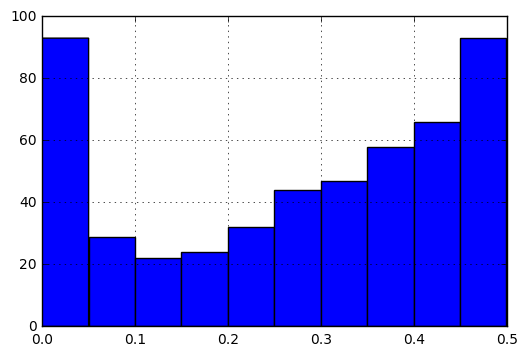

In [36]:
missed_test[missed_test['prediction'] == 0]['predict_proba'].hist()

In [37]:
missed_test[missed_test['prediction'] == 0].to_csv('false_negatives.csv')

In [38]:
fn = missed_test[missed_test['prediction'] == 0]
fn

,address,parcel_no,poly,sale_value,Latitude,Longitude,2YR NON-PROFIT HOUSE,BENEVOLENT/CHARITY,BOARD OF EDUCATION,CITY LAND BANK,CITY OWNED,COMMUNICATIONS,COUNTY LAND BANK,COUNTY OWNED,DETROIT HOUSING COMM,DISABLED VETERAN,EDUCATION/SCIENTIFIC,FEDERAL,HOSPITAL,NON-PROFIT,PA 245,PARSONAGE,PILOT,PROJECTS,PUBLIC LIGHTING,RAILROAD,REAL ESTATE DIVISION,RELIGIOUS,SEMTA,STATE LAND BANK,STATE OWNED,STATUTORY,TAXABLE,WATER DEPARTMENT,22-2-88(b),9-1-104,9-1-110(a),22-2-88(a),22-2-43,9-1-113,9-1-202,61-85.0100/32.0066,9-1-83 - (Structures < 5 stories),9-1-81(a),9-1-36(a),9-1-82(d) - (Structures < 5 stories),9-1-82(d) - (Dwelling),9-1-43(a) - (Dwelling),9-1-43(a) - (Structures),9-1-13,9-1-111,22-2-45,22-2-44,61-5-14 (9),9-1-107,9-1-111(a),9-1-50(a),61-85.0100/32.0031,22-2-16,22-2-17(a),22-2-49(a),9-1-82(b),9-1-91,61-82.0100/32.0066,9-1-101,22-2-41(b),61-81.0100/32.0066,9-1-103(C),9-1-36(d),9-1-36(c),61-84.0100/32.0076B,9-1-205,22-2-88,22-2-21(b),22-2-83(a)(b)(c),9-1-201(a),9-1-45,22-2-83(b),9-1-204,61-14-175,22-2-83(c),22-2-83,22-2-49(b),22-2-22(a),61-83.0100/32.0031,9-1-83 - (Dwelling),22-2-61,22-2-22,9-1-110(b),22-2-56,22-2-83(a)(c),9-1-81(e),9-1-105,22-2-38,22-2-49(c),61-5-18,9-1-112,9-1-82(d) - (Building 5 or more stories),22-2-49(d),61-84.0100/45.0807,...,522 - Water or steam leak,444 - Power line down,"118 - Trash or rubbish fire, contained",111 - Building fire,"600 - Good intent call, other","130 - Mobile property (vehicle) fire, other",411 - Gasoline or other flammable liquid spill,733 - Smoke detector activation due to malfunction,"150 - Outside rubbish fire, other","652 - Steam, vapor, fog or dust thought to be smoke","441 - Heat from short circuit (wiring), defective/worn","900 - Special type of incident, other","113 - Cooking fire, confined to container",743 - unintentional,"740 - Unintentional transmission of alarm, other",421 - Chemical hazard (no spill or leak),"712 - Direct tie to FD, malicious/false alarm","123 - Fire in portable building, fixed location","151 - Outside rubbish, trash or waste fire",131 - Automobile,"445 - Arcing, shorted electrical equipment",734 - Heat detector activation due to malfunction,"251 - Excessive heat, scorch burns with no ignition","115 - Incinerator overload or malfunction, fire confined",424 - CO incident [Carbon Monoxide],"400 - Hazardous condition, other",552 - Police matter,"471 - Explosive, bomb removal (for bomb scare, use 721)",742 - Extinguishing system activation,622 - No incident found on arrival at dispatch address,731 - Sprinkler activation due to malfunction,"746 - CO detector activation, no CO",744 - unintentional,741 - unintentional,"715 - Local alarm system, malicious false alarm","114 - Chimney or flue fire, confined to chimney or flue",735 - Alarm system sounded due to malfunction,"463 - Vehicle accident, general cleanup",721 - no bomb,"520 - Water problem, other","480 - Attempted burning, illegal action, other","210 - Overpressure rupture from steam, other",481 - Attempt to burn,"711 - Municipal alarm system, malicious false alarm",611 - Dispatched & cancelled en route,732 - Extinguishing system activation due to malfunction,"500 - Service Call, other",211 - Overpressure rupture of steam pipe or pipeline,736 - CO detector activation due to malfunction,"410 - Flammable gas or liquid condition, other",631 - Authorized controlled burning,"713 - Telephone, malicious false alarm","460 - Accident, potential accident, other",531 - Smoke or odor removal,"661 - EMS call, party transported by non-fire agency",222 - Overpressure rupture of boiler from air or gas,212 - Overpressure rupture of steam boiler,"140 - Natural vegetation fire, other",162 - Outside equipment fire,"142 - Brush, or brush and grass mixture fire",511 - Lock-out,"200 - Overpressure rupture, explosion, overheat other","141 - Forest, woods or wildland fire",154 - Dumpster or other outside trash receptacle fire,482 - Threat to burn,152 - Garbage dump or sanitary landfill fire,443 - Light ballast breakdown,621 - Wrong

In [39]:
tmp = missed_test[missed_test['prediction'] == 0].ix[:, 34:-3]
tmp = tmp[(tmp.T != -1).any()]
tmp = missed_test.loc[tmp.index,:]
tmp

,address,parcel_no,poly,sale_value,Latitude,Longitude,2YR NON-PROFIT HOUSE,BENEVOLENT/CHARITY,BOARD OF EDUCATION,CITY LAND BANK,CITY OWNED,COMMUNICATIONS,COUNTY LAND BANK,COUNTY OWNED,DETROIT HOUSING COMM,DISABLED VETERAN,EDUCATION/SCIENTIFIC,FEDERAL,HOSPITAL,NON-PROFIT,PA 245,PARSONAGE,PILOT,PROJECTS,PUBLIC LIGHTING,RAILROAD,REAL ESTATE DIVISION,RELIGIOUS,SEMTA,STATE LAND BANK,STATE OWNED,STATUTORY,TAXABLE,WATER DEPARTMENT,22-2-88(b),9-1-104,9-1-110(a),22-2-88(a),22-2-43,9-1-113,9-1-202,61-85.0100/32.0066,9-1-83 - (Structures < 5 stories),9-1-81(a),9-1-36(a),9-1-82(d) - (Structures < 5 stories),9-1-82(d) - (Dwelling),9-1-43(a) - (Dwelling),9-1-43(a) - (Structures),9-1-13,9-1-111,22-2-45,22-2-44,61-5-14 (9),9-1-107,9-1-111(a),9-1-50(a),61-85.0100/32.0031,22-2-16,22-2-17(a),22-2-49(a),9-1-82(b),9-1-91,61-82.0100/32.0066,9-1-101,22-2-41(b),61-81.0100/32.0066,9-1-103(C),9-1-36(d),9-1-36(c),61-84.0100/32.0076B,9-1-205,22-2-88,22-2-21(b),22-2-83(a)(b)(c),9-1-201(a),9-1-45,22-2-83(b),9-1-204,61-14-175,22-2-83(c),22-2-83,22-2-49(b),22-2-22(a),61-83.0100/32.0031,9-1-83 - (Dwelling),22-2-61,22-2-22,9-1-110(b),22-2-56,22-2-83(a)(c),9-1-81(e),9-1-105,22-2-38,22-2-49(c),61-5-18,9-1-112,9-1-82(d) - (Building 5 or more stories),22-2-49(d),61-84.0100/45.0807,...,522 - Water or steam leak,444 - Power line down,"118 - Trash or rubbish fire, contained",111 - Building fire,"600 - Good intent call, other","130 - Mobile property (vehicle) fire, other",411 - Gasoline or other flammable liquid spill,733 - Smoke detector activation due to malfunction,"150 - Outside rubbish fire, other","652 - Steam, vapor, fog or dust thought to be smoke","441 - Heat from short circuit (wiring), defective/worn","900 - Special type of incident, other","113 - Cooking fire, confined to container",743 - unintentional,"740 - Unintentional transmission of alarm, other",421 - Chemical hazard (no spill or leak),"712 - Direct tie to FD, malicious/false alarm","123 - Fire in portable building, fixed location","151 - Outside rubbish, trash or waste fire",131 - Automobile,"445 - Arcing, shorted electrical equipment",734 - Heat detector activation due to malfunction,"251 - Excessive heat, scorch burns with no ignition","115 - Incinerator overload or malfunction, fire confined",424 - CO incident [Carbon Monoxide],"400 - Hazardous condition, other",552 - Police matter,"471 - Explosive, bomb removal (for bomb scare, use 721)",742 - Extinguishing system activation,622 - No incident found on arrival at dispatch address,731 - Sprinkler activation due to malfunction,"746 - CO detector activation, no CO",744 - unintentional,741 - unintentional,"715 - Local alarm system, malicious false alarm","114 - Chimney or flue fire, confined to chimney or flue",735 - Alarm system sounded due to malfunction,"463 - Vehicle accident, general cleanup",721 - no bomb,"520 - Water problem, other","480 - Attempted burning, illegal action, other","210 - Overpressure rupture from steam, other",481 - Attempt to burn,"711 - Municipal alarm system, malicious false alarm",611 - Dispatched & cancelled en route,732 - Extinguishing system activation due to malfunction,"500 - Service Call, other",211 - Overpressure rupture of steam pipe or pipeline,736 - CO detector activation due to malfunction,"410 - Flammable gas or liquid condition, other",631 - Authorized controlled burning,"713 - Telephone, malicious false alarm","460 - Accident, potential accident, other",531 - Smoke or odor removal,"661 - EMS call, party transported by non-fire agency",222 - Overpressure rupture of boiler from air or gas,212 - Overpressure rupture of steam boiler,"140 - Natural vegetation fire, other",162 - Outside equipment fire,"142 - Brush, or brush and grass mixture fire",511 - Lock-out,"200 - Overpressure rupture, explosion, overheat other","141 - Forest, woods or wildland fire",154 - Dumpster or other outside trash receptacle fire,482 - Threat to burn,152 - Garbage dump or sanitary landfill fire,443 - Light ballast breakdown,621 - Wrong

In [40]:
fn[(fn['CITY LAND BANK'] == 1)]

,address,parcel_no,poly,sale_value,Latitude,Longitude,2YR NON-PROFIT HOUSE,BENEVOLENT/CHARITY,BOARD OF EDUCATION,CITY LAND BANK,CITY OWNED,COMMUNICATIONS,COUNTY LAND BANK,COUNTY OWNED,DETROIT HOUSING COMM,DISABLED VETERAN,EDUCATION/SCIENTIFIC,FEDERAL,HOSPITAL,NON-PROFIT,PA 245,PARSONAGE,PILOT,PROJECTS,PUBLIC LIGHTING,RAILROAD,REAL ESTATE DIVISION,RELIGIOUS,SEMTA,STATE LAND BANK,STATE OWNED,STATUTORY,TAXABLE,WATER DEPARTMENT,22-2-88(b),9-1-104,9-1-110(a),22-2-88(a),22-2-43,9-1-113,9-1-202,61-85.0100/32.0066,9-1-83 - (Structures < 5 stories),9-1-81(a),9-1-36(a),9-1-82(d) - (Structures < 5 stories),9-1-82(d) - (Dwelling),9-1-43(a) - (Dwelling),9-1-43(a) - (Structures),9-1-13,9-1-111,22-2-45,22-2-44,61-5-14 (9),9-1-107,9-1-111(a),9-1-50(a),61-85.0100/32.0031,22-2-16,22-2-17(a),22-2-49(a),9-1-82(b),9-1-91,61-82.0100/32.0066,9-1-101,22-2-41(b),61-81.0100/32.0066,9-1-103(C),9-1-36(d),9-1-36(c),61-84.0100/32.0076B,9-1-205,22-2-88,22-2-21(b),22-2-83(a)(b)(c),9-1-201(a),9-1-45,22-2-83(b),9-1-204,61-14-175,22-2-83(c),22-2-83,22-2-49(b),22-2-22(a),61-83.0100/32.0031,9-1-83 - (Dwelling),22-2-61,22-2-22,9-1-110(b),22-2-56,22-2-83(a)(c),9-1-81(e),9-1-105,22-2-38,22-2-49(c),61-5-18,9-1-112,9-1-82(d) - (Building 5 or more stories),22-2-49(d),61-84.0100/45.0807,...,522 - Water or steam leak,444 - Power line down,"118 - Trash or rubbish fire, contained",111 - Building fire,"600 - Good intent call, other","130 - Mobile property (vehicle) fire, other",411 - Gasoline or other flammable liquid spill,733 - Smoke detector activation due to malfunction,"150 - Outside rubbish fire, other","652 - Steam, vapor, fog or dust thought to be smoke","441 - Heat from short circuit (wiring), defective/worn","900 - Special type of incident, other","113 - Cooking fire, confined to container",743 - unintentional,"740 - Unintentional transmission of alarm, other",421 - Chemical hazard (no spill or leak),"712 - Direct tie to FD, malicious/false alarm","123 - Fire in portable building, fixed location","151 - Outside rubbish, trash or waste fire",131 - Automobile,"445 - Arcing, shorted electrical equipment",734 - Heat detector activation due to malfunction,"251 - Excessive heat, scorch burns with no ignition","115 - Incinerator overload or malfunction, fire confined",424 - CO incident [Carbon Monoxide],"400 - Hazardous condition, other",552 - Police matter,"471 - Explosive, bomb removal (for bomb scare, use 721)",742 - Extinguishing system activation,622 - No incident found on arrival at dispatch address,731 - Sprinkler activation due to malfunction,"746 - CO detector activation, no CO",744 - unintentional,741 - unintentional,"715 - Local alarm system, malicious false alarm","114 - Chimney or flue fire, confined to chimney or flue",735 - Alarm system sounded due to malfunction,"463 - Vehicle accident, general cleanup",721 - no bomb,"520 - Water problem, other","480 - Attempted burning, illegal action, other","210 - Overpressure rupture from steam, other",481 - Attempt to burn,"711 - Municipal alarm system, malicious false alarm",611 - Dispatched & cancelled en route,732 - Extinguishing system activation due to malfunction,"500 - Service Call, other",211 - Overpressure rupture of steam pipe or pipeline,736 - CO detector activation due to malfunction,"410 - Flammable gas or liquid condition, other",631 - Authorized controlled burning,"713 - Telephone, malicious false alarm","460 - Accident, potential accident, other",531 - Smoke or odor removal,"661 - EMS call, party transported by non-fire agency",222 - Overpressure rupture of boiler from air or gas,212 - Overpressure rupture of steam boiler,"140 - Natural vegetation fire, other",162 - Outside equipment fire,"142 - Brush, or brush and grass mixture fire",511 - Lock-out,"200 - Overpressure rupture, explosion, overheat other","141 - Forest, woods or wildland fire",154 - Dumpster or other outside trash receptacle fire,482 - Threat to burn,152 - Garbage dump or sanitary landfill fire,443 - Light ballast breakdown,621 - Wrong

In [41]:
tmp[tmp['CITY LAND BANK'] == 1]

,address,parcel_no,poly,sale_value,Latitude,Longitude,2YR NON-PROFIT HOUSE,BENEVOLENT/CHARITY,BOARD OF EDUCATION,CITY LAND BANK,CITY OWNED,COMMUNICATIONS,COUNTY LAND BANK,COUNTY OWNED,DETROIT HOUSING COMM,DISABLED VETERAN,EDUCATION/SCIENTIFIC,FEDERAL,HOSPITAL,NON-PROFIT,PA 245,PARSONAGE,PILOT,PROJECTS,PUBLIC LIGHTING,RAILROAD,REAL ESTATE DIVISION,RELIGIOUS,SEMTA,STATE LAND BANK,STATE OWNED,STATUTORY,TAXABLE,WATER DEPARTMENT,22-2-88(b),9-1-104,9-1-110(a),22-2-88(a),22-2-43,9-1-113,9-1-202,61-85.0100/32.0066,9-1-83 - (Structures < 5 stories),9-1-81(a),9-1-36(a),9-1-82(d) - (Structures < 5 stories),9-1-82(d) - (Dwelling),9-1-43(a) - (Dwelling),9-1-43(a) - (Structures),9-1-13,9-1-111,22-2-45,22-2-44,61-5-14 (9),9-1-107,9-1-111(a),9-1-50(a),61-85.0100/32.0031,22-2-16,22-2-17(a),22-2-49(a),9-1-82(b),9-1-91,61-82.0100/32.0066,9-1-101,22-2-41(b),61-81.0100/32.0066,9-1-103(C),9-1-36(d),9-1-36(c),61-84.0100/32.0076B,9-1-205,22-2-88,22-2-21(b),22-2-83(a)(b)(c),9-1-201(a),9-1-45,22-2-83(b),9-1-204,61-14-175,22-2-83(c),22-2-83,22-2-49(b),22-2-22(a),61-83.0100/32.0031,9-1-83 - (Dwelling),22-2-61,22-2-22,9-1-110(b),22-2-56,22-2-83(a)(c),9-1-81(e),9-1-105,22-2-38,22-2-49(c),61-5-18,9-1-112,9-1-82(d) - (Building 5 or more stories),22-2-49(d),61-84.0100/45.0807,...,522 - Water or steam leak,444 - Power line down,"118 - Trash or rubbish fire, contained",111 - Building fire,"600 - Good intent call, other","130 - Mobile property (vehicle) fire, other",411 - Gasoline or other flammable liquid spill,733 - Smoke detector activation due to malfunction,"150 - Outside rubbish fire, other","652 - Steam, vapor, fog or dust thought to be smoke","441 - Heat from short circuit (wiring), defective/worn","900 - Special type of incident, other","113 - Cooking fire, confined to container",743 - unintentional,"740 - Unintentional transmission of alarm, other",421 - Chemical hazard (no spill or leak),"712 - Direct tie to FD, malicious/false alarm","123 - Fire in portable building, fixed location","151 - Outside rubbish, trash or waste fire",131 - Automobile,"445 - Arcing, shorted electrical equipment",734 - Heat detector activation due to malfunction,"251 - Excessive heat, scorch burns with no ignition","115 - Incinerator overload or malfunction, fire confined",424 - CO incident [Carbon Monoxide],"400 - Hazardous condition, other",552 - Police matter,"471 - Explosive, bomb removal (for bomb scare, use 721)",742 - Extinguishing system activation,622 - No incident found on arrival at dispatch address,731 - Sprinkler activation due to malfunction,"746 - CO detector activation, no CO",744 - unintentional,741 - unintentional,"715 - Local alarm system, malicious false alarm","114 - Chimney or flue fire, confined to chimney or flue",735 - Alarm system sounded due to malfunction,"463 - Vehicle accident, general cleanup",721 - no bomb,"520 - Water problem, other","480 - Attempted burning, illegal action, other","210 - Overpressure rupture from steam, other",481 - Attempt to burn,"711 - Municipal alarm system, malicious false alarm",611 - Dispatched & cancelled en route,732 - Extinguishing system activation due to malfunction,"500 - Service Call, other",211 - Overpressure rupture of steam pipe or pipeline,736 - CO detector activation due to malfunction,"410 - Flammable gas or liquid condition, other",631 - Authorized controlled burning,"713 - Telephone, malicious false alarm","460 - Accident, potential accident, other",531 - Smoke or odor removal,"661 - EMS call, party transported by non-fire agency",222 - Overpressure rupture of boiler from air or gas,212 - Overpressure rupture of steam boiler,"140 - Natural vegetation fire, other",162 - Outside equipment fire,"142 - Brush, or brush and grass mixture fire",511 - Lock-out,"200 - Overpressure rupture, explosion, overheat other","141 - Forest, woods or wildland fire",154 - Dumpster or other outside trash receptacle fire,482 - Threat to burn,152 - Garbage dump or sanitary landfill fire,443 - Light ballast breakdown,621 - Wrong

In [42]:
fn[(fn['TAXABLE'] == 1) | fn['sale_value'] > 0]

,address,parcel_no,poly,sale_value,Latitude,Longitude,2YR NON-PROFIT HOUSE,BENEVOLENT/CHARITY,BOARD OF EDUCATION,CITY LAND BANK,CITY OWNED,COMMUNICATIONS,COUNTY LAND BANK,COUNTY OWNED,DETROIT HOUSING COMM,DISABLED VETERAN,EDUCATION/SCIENTIFIC,FEDERAL,HOSPITAL,NON-PROFIT,PA 245,PARSONAGE,PILOT,PROJECTS,PUBLIC LIGHTING,RAILROAD,REAL ESTATE DIVISION,RELIGIOUS,SEMTA,STATE LAND BANK,STATE OWNED,STATUTORY,TAXABLE,WATER DEPARTMENT,22-2-88(b),9-1-104,9-1-110(a),22-2-88(a),22-2-43,9-1-113,9-1-202,61-85.0100/32.0066,9-1-83 - (Structures < 5 stories),9-1-81(a),9-1-36(a),9-1-82(d) - (Structures < 5 stories),9-1-82(d) - (Dwelling),9-1-43(a) - (Dwelling),9-1-43(a) - (Structures),9-1-13,9-1-111,22-2-45,22-2-44,61-5-14 (9),9-1-107,9-1-111(a),9-1-50(a),61-85.0100/32.0031,22-2-16,22-2-17(a),22-2-49(a),9-1-82(b),9-1-91,61-82.0100/32.0066,9-1-101,22-2-41(b),61-81.0100/32.0066,9-1-103(C),9-1-36(d),9-1-36(c),61-84.0100/32.0076B,9-1-205,22-2-88,22-2-21(b),22-2-83(a)(b)(c),9-1-201(a),9-1-45,22-2-83(b),9-1-204,61-14-175,22-2-83(c),22-2-83,22-2-49(b),22-2-22(a),61-83.0100/32.0031,9-1-83 - (Dwelling),22-2-61,22-2-22,9-1-110(b),22-2-56,22-2-83(a)(c),9-1-81(e),9-1-105,22-2-38,22-2-49(c),61-5-18,9-1-112,9-1-82(d) - (Building 5 or more stories),22-2-49(d),61-84.0100/45.0807,...,522 - Water or steam leak,444 - Power line down,"118 - Trash or rubbish fire, contained",111 - Building fire,"600 - Good intent call, other","130 - Mobile property (vehicle) fire, other",411 - Gasoline or other flammable liquid spill,733 - Smoke detector activation due to malfunction,"150 - Outside rubbish fire, other","652 - Steam, vapor, fog or dust thought to be smoke","441 - Heat from short circuit (wiring), defective/worn","900 - Special type of incident, other","113 - Cooking fire, confined to container",743 - unintentional,"740 - Unintentional transmission of alarm, other",421 - Chemical hazard (no spill or leak),"712 - Direct tie to FD, malicious/false alarm","123 - Fire in portable building, fixed location","151 - Outside rubbish, trash or waste fire",131 - Automobile,"445 - Arcing, shorted electrical equipment",734 - Heat detector activation due to malfunction,"251 - Excessive heat, scorch burns with no ignition","115 - Incinerator overload or malfunction, fire confined",424 - CO incident [Carbon Monoxide],"400 - Hazardous condition, other",552 - Police matter,"471 - Explosive, bomb removal (for bomb scare, use 721)",742 - Extinguishing system activation,622 - No incident found on arrival at dispatch address,731 - Sprinkler activation due to malfunction,"746 - CO detector activation, no CO",744 - unintentional,741 - unintentional,"715 - Local alarm system, malicious false alarm","114 - Chimney or flue fire, confined to chimney or flue",735 - Alarm system sounded due to malfunction,"463 - Vehicle accident, general cleanup",721 - no bomb,"520 - Water problem, other","480 - Attempted burning, illegal action, other","210 - Overpressure rupture from steam, other",481 - Attempt to burn,"711 - Municipal alarm system, malicious false alarm",611 - Dispatched & cancelled en route,732 - Extinguishing system activation due to malfunction,"500 - Service Call, other",211 - Overpressure rupture of steam pipe or pipeline,736 - CO detector activation due to malfunction,"410 - Flammable gas or liquid condition, other",631 - Authorized controlled burning,"713 - Telephone, malicious false alarm","460 - Accident, potential accident, other",531 - Smoke or odor removal,"661 - EMS call, party transported by non-fire agency",222 - Overpressure rupture of boiler from air or gas,212 - Overpressure rupture of steam boiler,"140 - Natural vegetation fire, other",162 - Outside equipment fire,"142 - Brush, or brush and grass mixture fire",511 - Lock-out,"200 - Overpressure rupture, explosion, overheat other","141 - Forest, woods or wildland fire",154 - Dumpster or other outside trash receptacle fire,482 - Threat to burn,152 - Garbage dump or sanitary landfill fire,443 - Light ballast breakdown,621 - Wrong

In [43]:
true_test = test[test['prediction'] == test['is_blighted']]

In [44]:
true_test[true_test['prediction'] == 1].to_csv('true_positives.csv')